<a href="https://colab.research.google.com/github/Alyxx-The-Sniper/CNN/blob/main/Model_Deployment_(Part_5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Food Classification (Part 5)
Model Deployment



During the Food Classification (Part 4) phase, we compared multiple models and determined that the Vision Transformer model, despite its larger file size, demonstrated superior performance in terms of loss and accuracy. Now, as we move forward with the project, we need to carefully evaluate and compare the performance of different models to make an informed decision for deployment.

In particular, we will focus on comparing the EfficientNet B0 model, which offers reasonably good results and has a smaller file size, with the ViT B16 (Weights.IMAGENET1K_SWAG_E2E_V1) model. Our comparison will consider various factors to determine which model best meets our deployment requirements.

For the deployment of our Food Classification Model in a demo Gradio app on a smartphone device, we have set specific metrics to achieve:

1. Performance: We aim for an accuracy of 90% or higher, ensuring reliable food classification.
2. Speed: Real-time inference of 30FPS-50FPS (frames per second) or more, ensuring fast and responsive predictions. Each prediction should have a latency of less than approximately 0.03 - 0.04 seconds.

By carefully evaluating and comparing these metrics, we can make an informed decision about the most suitable model for our deployment scenario.



---







# Data Preparation

###Download Necessary Modular Script
We will download Python scripts that enable code reuse for our analysis. These scripts will provide functionality that can be utilized across different parts of our analysis, allowing us to save time and effort in writing redundant code.


In [1]:
from pathlib import Path
import shutil
import os
import sys


# Function to copy necessary scripts
def copy_drive_script(source_file_path: str, destination_file_path: str):
    copy(source_file_path, destination_file_path)
    print("File copied successfully!")

# Modular Script Path
Path_scripts = Path('/content/drive/MyDrive/Deep_learning/Modular_Script')

source = [Path_scripts / 'get_data.py',
          Path_scripts / 'data_setup.py',
          # Path_scripts / 'model_builder.py',
          Path_scripts / 'engine.py',
          Path_scripts / 'utils.py',
          Path_scripts / 'train.py',
          Path_scripts / 'predict.py',
          Path_scripts / '__init__.py']

destination = ['modular_codes/get_data.py',
               'modular_codes/data_setup.py',
              #  'modular_codes/model_builder.py',
               'modular_codes/engine.py',
               'modular_codes/utils.py',
               'modular_codes/train.py',
               'modular_codes/predict.py',
               'modular_codes/__init__.py']

# Copy from source to location
for src, dest in zip(source, destination):
    # Create the destination directory if it doesn't exist
    if not os.path.exists(os.path.dirname(dest)):
        os.makedirs(os.path.dirname(dest))

    try:
        shutil.copy(src, dest)
        print('File copied successfully!')
    except FileNotFoundError:
        print(f"Error: File '{src}' not found.")



File copied successfully!
File copied successfully!
File copied successfully!
File copied successfully!
File copied successfully!
File copied successfully!
File copied successfully!


###Setup device-agnostic code

In [2]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get_data

We will obtain a 20% sample of the images. The downloaded data is already in the standard format for image classification.

In [3]:
!python modular_codes/get_data.py --food_list 'cup_cakes,donuts,french_fries,ice_cream' --copy_percentage 0.2

[INFO] Copying 0.2 percent of ['cup_cakes', 'donuts', 'french_fries', 'ice_cream']
100%|█████████████████████████████████████████| 150/150 [01:26<00:00,  1.74it/s]
Download Complete


###Setup train and test directories


In [4]:
train_dir = Path('data/my_fav_foods/train')
test_dir = Path('data/my_fav_foods/test')

###Transforms
We will utilize the IMAGENET1K_SWAG_E2E_V1 weight for the ViT B16 model, while for the EfficientNet B0 model, we will select the best available weight.

In [5]:
import torchvision

# weight and transform for effnet_b0
weights_effnet_b0 = torchvision.models.EfficientNet_B0_Weights.DEFAULT
transforms_effnet_b0 = weights_effnet_b0.transforms()

# weight and transform for vit_b_16
weights_vit_b_16 = torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1
transforms_vit_b_16 = weights_vit_b_16.transforms()

###Dataloaders

To accommodate the different transforms required by each model, we will create separate dataloaders for each.

In [6]:
from modular_codes import data_setup

BATCH_SIZE = 32

# dataloader for effent_b0
train_dataloader_effnetb0, test_dataloader_effnetb0, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=transforms_effnet_b0,
                                                                                                 batch_size=BATCH_SIZE)
# dataloader for vit_b_16
train_dataloader_vit_b_16, test_dataloader_vit_b_16, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=transforms_vit_b_16,
                                                                                                 batch_size=BATCH_SIZE)

#Creating Models

We will define a function to create EfficientNet_B0 and ViT_B_16 Swag models.

In [7]:
from torch import nn
from modular_codes.utils import set_seeds

# Get num out features (one for each class pizza, steak, sushi)
OUT_FEATURES = len(class_names)

In [8]:
# Create an EffNetB0 feature extractor
def create_effnetb0():
    # 1. Get the base mdoel with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model.")
    return model

def create_vit_b_16_swag():
   # 1. Get the base mdoel with pretrained weights and send to target device
    weights = torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the heads
    model.heads = nn.Linear(in_features=768,
                            out_features=len(class_names)).to(device)

    # 5. Give the model a name
    model.name = "vit_b_16_swag"
    print(f"[INFO] Created new {model.name} model.")
    return model

In [9]:
# create models
effnetb0 = create_effnetb0()
vit_b_16_swag = create_vit_b_16_swag()

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 93.1MB/s]


[INFO] Created new effnetb0 model.


Downloading: "https://download.pytorch.org/models/vit_b_16_swag-9ac1b537.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16_swag-9ac1b537.pth
100%|██████████| 331M/331M [00:03<00:00, 91.9MB/s]


[INFO] Created new vit_b_16_swag model.


#Training...

Loss and Optimizer

In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer_effnetb0 = torch.optim.Adam(effnetb0.parameters(), lr=0.001)
optimizer_vit_b_16_swag = torch.optim.Adam(vit_b_16_swag.parameters(), lr=0.001)

effnetb0 training

In [11]:
from modular_codes import engine

set_seeds()
effnetb0_results = engine.train(model=effnetb0,
                                train_dataloader=train_dataloader_effnetb0,
                                test_dataloader=test_dataloader_effnetb0,
                                epochs=10,
                                optimizer=optimizer_effnetb0,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2005 | train_acc: 0.5022 | test_loss: 0.7787 | test_acc: 0.8795
Epoch: 2 | train_loss: 0.8338 | train_acc: 0.7769 | test_loss: 0.5824 | test_acc: 0.8973
Epoch: 3 | train_loss: 0.6564 | train_acc: 0.8350 | test_loss: 0.4749 | test_acc: 0.8973
Epoch: 4 | train_loss: 0.5758 | train_acc: 0.8333 | test_loss: 0.4262 | test_acc: 0.9107
Epoch: 5 | train_loss: 0.5113 | train_acc: 0.8547 | test_loss: 0.3884 | test_acc: 0.9152
Epoch: 6 | train_loss: 0.4722 | train_acc: 0.8799 | test_loss: 0.3594 | test_acc: 0.9107
Epoch: 7 | train_loss: 0.4323 | train_acc: 0.8750 | test_loss: 0.3437 | test_acc: 0.9152
Epoch: 8 | train_loss: 0.3945 | train_acc: 0.8947 | test_loss: 0.3334 | test_acc: 0.9152
Epoch: 9 | train_loss: 0.3763 | train_acc: 0.9123 | test_loss: 0.3204 | test_acc: 0.9107
Epoch: 10 | train_loss: 0.3832 | train_acc: 0.8898 | test_loss: 0.3078 | test_acc: 0.9196


vit_b_16_swag training

In [12]:
set_seeds()
vit_b_16_swag_results = engine.train(model=vit_b_16_swag,
                                train_dataloader=train_dataloader_vit_b_16,
                                test_dataloader=test_dataloader_vit_b_16,
                                epochs=10,
                                optimizer=optimizer_vit_b_16_swag,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4769 | train_acc: 0.8481 | test_loss: 0.0782 | test_acc: 0.9732
Epoch: 2 | train_loss: 0.1152 | train_acc: 0.9649 | test_loss: 0.0608 | test_acc: 0.9777
Epoch: 3 | train_loss: 0.0738 | train_acc: 0.9759 | test_loss: 0.0599 | test_acc: 0.9821
Epoch: 4 | train_loss: 0.0518 | train_acc: 0.9934 | test_loss: 0.0502 | test_acc: 0.9866
Epoch: 5 | train_loss: 0.0389 | train_acc: 0.9967 | test_loss: 0.0499 | test_acc: 0.9866
Epoch: 6 | train_loss: 0.0311 | train_acc: 1.0000 | test_loss: 0.0484 | test_acc: 0.9866
Epoch: 7 | train_loss: 0.0246 | train_acc: 1.0000 | test_loss: 0.0454 | test_acc: 0.9821
Epoch: 8 | train_loss: 0.0207 | train_acc: 1.0000 | test_loss: 0.0460 | test_acc: 0.9866
Epoch: 9 | train_loss: 0.0180 | train_acc: 1.0000 | test_loss: 0.0447 | test_acc: 0.9866
Epoch: 10 | train_loss: 0.0153 | train_acc: 1.0000 | test_loss: 0.0417 | test_acc: 0.9866


Save The Models

In [13]:
from modular_codes.utils import save_model

save_model(model = effnetb0,
           target_dir = 'models',
           model_name = 'effnetb0_data20_10epoch.pth')

save_model(model = vit_b_16_swag,
           target_dir = 'models',
           model_name = 'vit_b_16_swag_data20_10epoch.pth')

# save a copy to google drive
# Source directory path
source_directory = '/content/models'

# Destination directory path
destination_directory = '/content/drive/MyDrive/Deep_learning/Best_Models'

# Check if the destination directory already exists
if os.path.exists(destination_directory):
    print("Files downloaded.")
else:
    # Copy the contents of the source directory to the destination directory
    shutil.copytree(source_directory, destination_directory)

[INFO] Saving model to: models/effnetb0_data20_10epoch.pth
[INFO] Saving model to: models/vit_b_16_swag_data20_10epoch.pth
Files downloaded.


# Training Results: Comparing the Best Model

In this section, we compare the training results of both models based on various factors such as file size, trainable parameters, test and accuracy loss, and average prediction per sample. This comparison will help us determine the best model for our task.


1. Size

In [14]:
# Get the model size in bytes then convert to megabytes
effnetb0_size = Path('/content/models/effnetb0_data20_10epoch.pth').stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
vit_b_16_swag_size = Path('/content/models/vit_b_16_swag_data20_10epoch.pth').stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
effnetb0_size, vit_b_16_swag_size

(15, 328)

2. Total Trainable Params

In [15]:
effnetb0_params = sum(torch.numel(param) for param in effnetb0.parameters())
vit_b_16_swag_params = sum(torch.numel(param) for param in vit_b_16_swag.parameters())
effnetb0_params, vit_b_16_swag_params


(4012672, 86093572)

3. Test Loss and Accuracy
<br/>
Retrieve the test loss and accuracy values and store them in a dictionary for further analysis and reference.

In [16]:
effnetb0_stats = {"test_loss":  effnetb0_results["test_loss"][-1],
                  "test_acc":  effnetb0_results["test_acc"][-1],
                  "number_of_parameters": effnetb0_params,
                  "model_size (MB)": effnetb0_size}

vit_b_16_swag_stats = {"test_loss": vit_b_16_swag_results["test_loss"][-1],
                         "test_acc": vit_b_16_swag_results["test_acc"][-1],
                         "number_of_parameters": vit_b_16_swag_params,
                          "model_size (MB)": vit_b_16_swag_size}

effnetb0_stats,vit_b_16_swag_stats

({'test_loss': 0.3077719637325832,
  'test_acc': 0.9196428571428571,
  'number_of_parameters': 4012672,
  'model_size (MB)': 15},
 {'test_loss': 0.04172749366677765,
  'test_acc': 0.9866071428571429,
  'number_of_parameters': 86093572,
  'model_size (MB)': 328})

4. Average Prediction Time per Sample
<br/>
To determine the average prediction time, we will gather all the test images and store them in a single path. Next, we will make predictions on these images. The resulting predictions will be converted into a Pandas DataFrame, allowing us to perform further data analysis, specifically to calculate the average prediction time.


 - Get all test data paths

In [17]:
print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
# len(test_data_paths), test_data_paths[:5]

[INFO] Finding all filepaths ending with '.jpg' in directory: data/my_fav_foods/test


- Predict and store in a dictionary
<br/>
To ensure an accurate measurement of prediction time without utilizing the processing power of the GPU, the device was set to 'cpu'. By doing so, we eliminated the advantage of using the GPU for faster computations.
<br/>
Therefore, by setting the device to 'cpu', we obtained reliable and comparable prediction times for evaluation purposes.

In [18]:
from modular_codes.utils import pred_and_store

effnetb0_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb0,
                                          transform=transforms_effnet_b0,
                                          class_names=class_names,
                                          device='cpu')


vit_b_16_swag_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                               model=vit_b_16_swag,
                                               transform=transforms_vit_b_16,
                                               class_names=class_names,
                                               device='cpu')

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

- Turn dictionaries into a DataFrame

In [19]:
import pandas as pd

effnetb0_df = pd.DataFrame(effnetb0_test_pred_dicts)
vit_b_16_swag_df = pd.DataFrame(vit_b_16_swag_test_pred_dicts)


# save a copy of dataframe result to google drive for further analysis
# Save effnetb0_df in a specific directory
effnetb0_df.to_csv('/content/drive/MyDrive/Deep_learning/Best_Models/effnetb0_df.csv', index=True)

# Save vit_b_16_swag_df in a specific directory
vit_b_16_swag_df.to_csv('/content/drive/MyDrive/Deep_learning/Best_Models/vit_b_16_swag_df.csv', index=True)

- Add a column named 'model' and concatenate

In [35]:
effnetb0_df['model'] = 'effnetb0'
vit_b_16_swag_df['model'] = 'vit_b_16_swag_'

# Concatenate the dataframes vertically
df = pd.concat([effnetb0_df, vit_b_16_swag_df], ignore_index=True)

# Move the "model" column to the first position
cols = df.columns.tolist()
cols = ['model'] + cols[:-1]
df = df[cols]

df.sample(5)

,model,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
21,effnetb0,data/my_fav_foods/test/ice_cream/1756584.jpg,ice_cream,0.8468,ice_cream,0.0423,True
196,effnetb0,data/my_fav_foods/test/donuts/2330100.jpg,donuts,0.9843,donuts,0.0421,True
328,vit_b_16_swag_,data/my_fav_foods/test/french_fries/2596038.jpg,french_fries,0.9996,french_fries,0.9339,True
206,vit_b_16_swag_,data/my_fav_foods/test/ice_cream/698179.jpg,ice_cream,0.9999,ice_cream,0.9017,True
67,effnetb0,data/my_fav_foods/test/cup_cakes/835932.jpg,cup_cakes,0.9921,cup_cakes,0.0389,True


Now that we have stored all our useful information in a dataframe, we can perform further analysis and exploration at a later stage.

- Calculate the average speed

In [36]:
effnetb0_avg_time_per_pred = round(effnetb0_df.time_for_pred.mean(), 4)
vit_b_16_swag_df_avg_time_per_pred = round(vit_b_16_swag_df.time_for_pred.mean(), 4)
print(effnetb0_avg_time_per_pred)
print(vit_b_16_swag_df_avg_time_per_pred)

# adding avg_speed  column to our dictionary
effnetb0_stats['avg_speed'] = effnetb0_avg_time_per_pred
vit_b_16_swag_stats['avg_speed'] = vit_b_16_swag_df_avg_time_per_pred
print(effnetb0_stats)
print(vit_b_16_swag_stats)

0.0425
1.0228
{'test_loss': 0.3077719637325832, 'test_acc': 0.9196428571428571, 'number_of_parameters': 4012672, 'model_size (MB)': 15, 'avg_speed': 0.0425}
{'test_loss': 0.04172749366677765, 'test_acc': 0.9866071428571429, 'number_of_parameters': 86093572, 'model_size (MB)': 328, 'avg_speed': 1.0228}


- Convert both dictionaries into Pandas DataFrames for better visualization and ease of analysis.



In [37]:
# Turn stat dictionaries into DataFrame
df_stats = pd.DataFrame([effnetb0_stats, vit_b_16_swag_stats])

# Add column for model names
df_stats["model"] = ["EffNetB0", "ViT_B_16_Swag"]

# Move "model" column to the first position
cols = df_stats.columns.tolist()
cols = ["model"] + cols[:-1]
df_stats = df_stats[cols]

# Convert accuracy to percentages
df_stats["test_acc"] = round(df_stats["test_acc"] * 100, 2)

df_stats

,model,test_loss,test_acc,number_of_parameters,model_size (MB),avg_speed
0,EffNetB0,0.307772,91.96,4012672,15,0.0425
1,ViT_B_16_Swag,0.041727,98.66,86093572,328,1.0228


Based on the results, the EffNetB0 model achieved a test accuracy of 91.96% with a test loss of 0.307772. It has a relatively smaller model size of 15 MB and a faster average speed of 0.0424 seconds per prediction. The number of parameters in the EffNetB0 model is 4,012,672.

Considering our model deployment scenario, where we are using a phone to classify foods, it is important to prioritize computational efficiency. Since the majority of phone holders is likely to have phones with limited computational power, the EffNetB0 model is more appropriate. Its smaller model size and faster prediction speed make it suitable for deployment on devices with constrained resources.

In contrast, the ViT_B_16_Swag model achieved a higher test accuracy of 98.66% with a lower test loss of 0.041728. However, it comes with a larger model size of 328 MB and a slower average speed of 0.9962 seconds per prediction. These factors make it less suitable for deployment on resource-constrained devices like phones.

Therefore, considering the need for efficient model deployment on phones, we have selected the EffNetB0 model. Its smaller file size and faster prediction results make it a more suitable choice for our target audience, ensuring a smooth and efficient user experience on their devices.



---



---



# Gradio Demo App
The structure of the demo we're going to create is as follows:

1. Input: Image
2. Transformation: Apply necessary transformations to the input image
3. Prediction : Feed the transformed image into the model for prediction
4. Output: Retrieve the prediction result, prediction probabilities, and the time taken for the prediction

The gradio interface look like this.

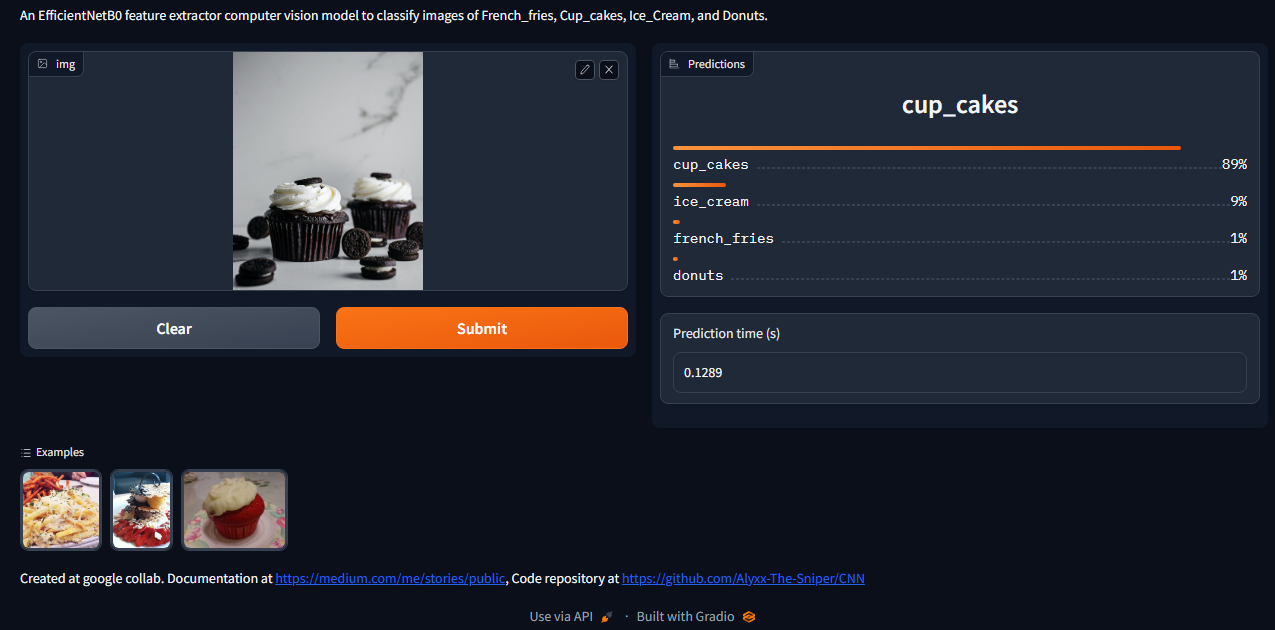

Install Gradio

In [23]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

# print(f"Gradio version: {gr.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 77.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 75.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.4/288.4 kB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.0 MB/s eta 0:0

Creating a function to map our inputs and outputs
<br/>
Our function will enables us to go from inputs -> transform -> ML model -> outputs.

In [24]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = transforms_effnet_b0(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb0.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb0(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    end_time = timer()
    pred_time = end_time - start_time

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

Test run our function on randomly selected images from test data

[INFO] Predicting on image at path: data/my_fav_foods/test/french_fries/3293202.jpg

Prediction label and probability dictionary: 
{'cup_cakes': 0.0003575534501578659, 'donuts': 0.00026132960920222104, 'french_fries': 0.9989250302314758, 'ice_cream': 0.0004560428496915847}
Prediction time: 0.04335417300012523 seconds


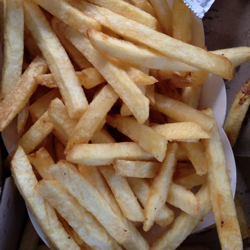

In [25]:
import random
from PIL import Image
from timeit import default_timer as timer

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")
image.resize((250, 250))

We can replicate this in the gradio.Interface() class with the following parameters:

- fn - a Python function to map inputs to outputs, in our case, we'll use our predict() function.
- inputs - the input to our interface, such as an image using gradio.Image() or "image".
- outputs - the output of our interface once the inputs have gone through the fn, such as a label using
     <br/>
  > gradio.Label() --> (for our model's predicted labels) or number using
    <br/>
  > gradio.Number() --> (for our model's prediction time).

Note: Our predict function has two return values, we will need two output variables as well.

In [26]:
import gradio as gr

# Create a list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]

# Create title, description and article strings
title = "Food Classifier"
description = "An EfficientNetB0 feature extractor computer vision model to classify images of French_fries, Cup_cakes, Ice_Cream, and Donuts."
article = "Created at google collab. Documentation at https://medium.com/me/stories/public, Code repository at https://github.com/Alyxx-The-Sniper/CNN "


# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=4, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs!!
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=False, # print errors locally?
            share=False) # generate a publically shareable URL?

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

# Files Preparation For Uploading In HuggingFace

In order to upload our demo Gradio app, we need to organize all the relevant files and directories into a single directory.



In [27]:
## demos/
## └── foodvision_classification/
##       ├── 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
##       ├── app.py
##       ├── examples/
##       │   ├── example_1.jpg
##       │   ├── example_2.jpg
##       │   └── example_3.jpg
##       ├── model.py
##       └── requirements.txt\

#### **Set up the food_classification directories**
1. Create the `demos` directory.
2. Within the `demos` directory, create the `food_classification` subdirectory.
3. Inside the `food_classification` subdirectory, create the `examples` directory.
4. Place three sample images into the `examples` directory.
5. Move the pretrained model file to the `food_classification` directory.

In [28]:
import shutil
from pathlib import Path

# Create path
food_classification_path = Path("demos/food_classification/")

# 0. Remove files that might already exist there and create new directory
if food_classification_path.exists():
    shutil.rmtree(food_classification_path)
food_classification_path.mkdir(parents=True, exist_ok=True)

# 1. Create an examples directory
food_image_examples_path = food_classification_path / "examples"
food_image_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three test dataset image paths
food_image_examples = [Path('data/my_fav_foods/test/french_fries/2740844.jpg'),
                       Path('data/my_fav_foods/test/ice_cream/387707.jpg'),
                       Path('data/my_fav_foods/test/cup_cakes/529481.jpg')]

# 3. Copy the three images to the examples directory
for example in food_image_examples:
    destination = food_image_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

# 4 move model
shutil.move('/content/models/effnetb0_data20_10epoch.pth',
            '/content/demos/food_classification/')

[INFO] Copying data/my_fav_foods/test/french_fries/2740844.jpg to demos/food_classification/examples/2740844.jpg
[INFO] Copying data/my_fav_foods/test/ice_cream/387707.jpg to demos/food_classification/examples/387707.jpg
[INFO] Copying data/my_fav_foods/test/cup_cakes/529481.jpg to demos/food_classification/examples/529481.jpg


'/content/demos/food_classification/effnetb0_data20_10epoch.pth'

#### **model.py**

In [29]:
# 5 Turning our EffNetB0 model into a Python script (model.py)

%%writefile demos/food_classification/model.py
import torchvision
from torch import nn

def create_effnetb0(num_classes:int=4, seed:int=42):
    # 1. Get the base mdoel with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b0(weights=weights)#.to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=num_classes)
    )#.to(device)

    # 5. Give the model a name
    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model.")
    return model, transforms

Writing demos/food_classification/model.py


#### **app.py**




In [30]:
# 6. Turning our FoodVision Mini Gradio app into a Python script (app.py)

%%writefile demos/food_classification/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb0
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ['cup_cakes', 'donuts', 'french_fries', 'ice_cream']

### 2. Model and transforms preparation ###

# Create EffNetB0 model
effnetb0, effnetb0_transforms = create_effnetb0()

# Load saved weights
effnetb0.load_state_dict(
    torch.load(
        f="effnetb0_data20_10epoch.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)


### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb0_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb0.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb0(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time


### 4. Gradio app ###

# Create title, description and article strings
title = "Food Classifier"
description = "An EfficientNetB0 feature extractor computer vision model to classify images of French_fries, Cup_cakes, Ice_Cream, and Donuts."
article = "Created at google collab. Documentation at https://medium.com/me/stories/public, Code repository at https://github.com/Alyxx-The-Sniper/CNN "

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict,  # mapping function from input to output
                    inputs=gr.Image(type="pil"),  # what are the inputs?
                    outputs=[gr.Label(num_top_classes=4, label="Predictions"),  # what are the outputs?
                             gr.Number(label="Prediction time (s)")],
                    # our fn has two outputs, therefore we have two outputs
                    # Create examples list from "examples/" directory
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()


Writing demos/food_classification/app.py


#### **requirement.txt**

In [31]:
%%writefile demos/food_classification/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

Writing demos/food_classification/requirements.txt


Check directories

In [32]:
!ls demos/food_classification

app.py	effnetb0_data20_10epoch.pth  examples  model.py  requirements.txt


#### **ZIP and Download**


In [33]:
import shutil
from google.colab import files

# Specify the source directory
source_dir = '/content/demos/food_classification'

# Specify the destination zip file path
zip_file_path = '/content/demos/food_classification'

# Create a zip file containing all files in the directory
shutil.make_archive(zip_file_path, 'zip', source_dir)

# Download the zip file
files.download(zip_file_path + '.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Code Test Run**

Testing our code can be done by packaging it along with the necessary files and running the `app.py` file in a Python interactive environment such as VSCode or PyCharm. This approach allows us to conveniently debug and manage our code while ensuring that all dependencies and configurations are properly set up. By executing the `app.py` file in the chosen Python environment, we can observe the behavior of our application, identify any potential issues, and make necessary adjustments to improve its functionality.



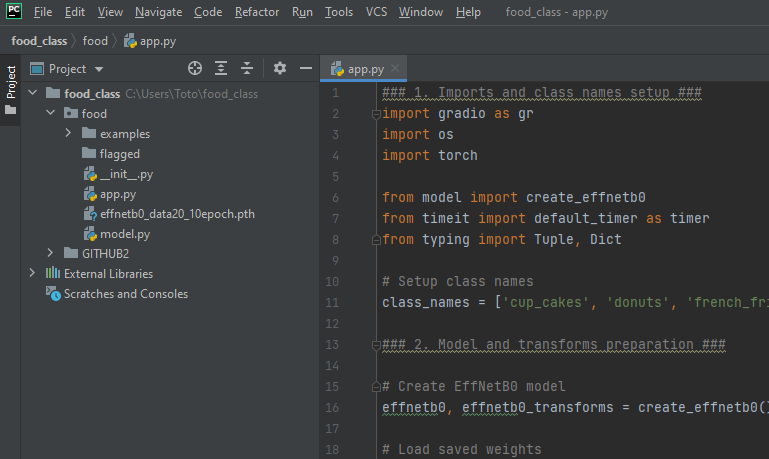

# **Uploading File to HuggingFace**

To publish our Gradio app on Hugging Face, follow these steps:

1. Log in to our Hugging Face account.
2. Go to the "Spaces" section and click on "Add New Space".
3. Provide a suitable name and description for the repository that accurately represents the Gradio app.
4. Select "Gradio" as the space SDK, and click on "Create Space".
5. Once the space is created, we will be redirected to a new page. Clone the repository by copying the code provided.
6. Go to the directory where we you have downloaded the "food_classification" directory. Copy or move all the files from the "food_classification" directory into the newly created repository by Hugging Face.
7. Open a bash terminal and navigate to the cloned repository on your local drive. (using 'cd' command)
8. Perform the following Git commands in the terminal:
   - Run `git status` to check the status of the repository.
   - Run `git add *` to stage all the files for commit.
   - Run `git commit -m 'adding files'` to commit the changes with a descriptive message.
   - Run `git push` to push the committed changes to your Hugging Face repository.
9. Wait for approximately 5-15 minutes for the app to function normally on your Hugging Face account.

By following these steps, you will successfully publish your Gradio app on Hugging Face, making it accessible to others in the Hugging Face community.


Check this link for our deployed Machine Learning App.

[Food_Classification_V0](https://huggingface.co/spaces/kaiku03/Food_Classification_V0)



---



---

